In [82]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt

In [83]:
transforms = []
transforms.append(torchvision.transforms.ToTensor())
transforms = torchvision.transforms.Compose(transforms)
MNIST_train = torchvision.datasets.MNIST('../../dataset/', train=True, transform=transforms)
MNIST_test = torchvision.datasets.MNIST('../../dataset/', train=False, transform=transforms)


In [84]:
MNIST_train[0][0].shape

torch.Size([1, 28, 28])

In [85]:
batch = 64

train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size=batch, shuffle=True)

In [86]:
class AutoEncoder(nn.Module):
	def __init__(self):
		super(AutoEncoder, self).__init__()
		self.encoder = nn.Sequential(
			nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2),

			nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2),

			nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2),
		)
		self.fc1 = nn.Linear(3*3*128, 32)
		self.fc2 = nn.Linear(32, 3*3*128)
		self.decoder = nn.Sequential(
			nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
			nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
			nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
			nn.Sigmoid()
		)

	def forward(self, x):
		x = self.encoder(x)
		x = x.reshape((x.size(0), -1))
		x = self.fc1(x)

		x = self.fc2(x)
		x = x.reshape((x.size(0), 128, 3, 3))
		x = self.decoder(x)
		return x

In [87]:
model = AutoEncoder()
model = model.to('cuda')
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
              ReLU-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 3, 3]               0
           Linear-10                   [-1, 32]          36,896
           Linear-11                 [-1, 1152]          38,016
  ConvTranspose2d-12             [-1, 64, 7, 7]          73,792
  ConvTranspose2d-13           [-1, 32, 14, 14]          18,464
  ConvTranspose2d-14            [-1, 1,

In [95]:
lr = 10**-1
optim = torch.optim.SGD(params=model.parameters(), lr=lr)

epoch = 10
loss_fn = nn.BCELoss()

In [101]:
for epoch_cnt in range(epoch):
	print_loss = 0
	for input, number in train_loader:
		optim.zero_grad()
		input = input.to('cuda')
		result = input.to('cuda')
		output = model(input)

		loss = loss_fn(output, result)
		loss.backward()
		print_loss = print_loss + loss.item()
		optim.step()
		
	print(print_loss / len(train_loader))

0.09093363081087182
0.09051416011284917
0.09013873194930141
0.0897883334790847
0.08943763170351605
0.089148978585564
0.08882161668305204
0.08859301398176628
0.08833907847243078
0.08807519492881893


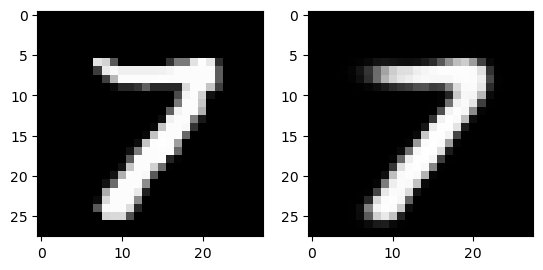

In [105]:
number = 34
img = model(MNIST_test[number][0].to('cuda').reshape(1, 1, 28, 28)).reshape(1, 28, 28)

topilimage = torchvision.transforms.ToPILImage()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(topilimage(MNIST_test[number][0]), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(topilimage(img), cmap='gray')